In [23]:
import pandas as pd ; import numpy as np ; import statsmodels.api as sm
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data_train=pd.read_csv('./dataset_housing_preprocesado_train.csv')
data_test=pd.read_csv('./dataset_housing_preprocesado_test.csv')


In [24]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Columns: 153 entries, LotFrontage to Foundation_PConc
dtypes: float64(2), int64(151)
memory usage: 933.7 KB


In [25]:
del(data_train['Exterior_CBlock'])  #borramos la columna de ceros que no nos dejaba hacer la matriz de covarianza

Ahora procedemos a eliminar aquellas variables colineales, las detectaremos al ver en la matriz de correlación valores superiores a | 0.8 |, ya que nos ha parecido un valor óptimo para ver las colineales. Tiene que ser valor absoluto ya que pueder ser colineales y tener correlación negativa.

In [26]:
matriz_cor=data_train.corr()
data_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Columns: 152 entries, LotFrontage to Foundation_PConc
dtypes: float64(2), int64(150)
memory usage: 927.6 KB


In [27]:
data_train_aux = data_train
cols = data_train.columns
rank = np.linalg.matrix_rank(data_train.cov())

for col in cols:
    cols2 = cols.drop(col)
    data_train_aux = data_train_aux[cols2]
    rank2 = np.linalg.matrix_rank(data_train_aux.cov())
    if rank == rank2:
        cols = cols2 #si el rango es igual la columna era linealmente dep
    else:
        data_train_aux = data_train #si no habremos bajado un rango porque era indep


data_train = data_train[cols]
print(data_train.columns)
print(np.linalg.matrix_rank(data_train.cov()))

matriz_cor=data_train.cov()



Index(['LotFrontage', 'LotArea', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       ...
       'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Hip',
       'RoofStyle_Other', 'MasVnrType_BrkFace', 'MasVnrType_None',
       'MasVnrType_Stone', 'Foundation_CBlock', 'Foundation_Other',
       'Foundation_PConc'],
      dtype='object', length=140)
140


In [28]:
#Dividimos los datos entre la variable objetivo/dependiente (y) y las variables independientes
x_train = data_train.drop('SalePrice', axis=1)
y_train = data_train['SalePrice']
x_test  = data_test.drop("SalePrice", axis=1)
y_test  = data_test["SalePrice"]

SEMANA 2


Paso 1: Construcción de un modelo lineal con librería statsmodels


• Construye un modelo de regresión para el dataset anterior usando la libreríastatsmodels. ¿Obtiene los mismos coeficientes que sklearn? ¿Los coeficientes de determinación son iguales? ¿Es el QQ-plot el esperado para un modelo de regresión lineal?



Al construir el modelo de regresión lineal con statsmodels miramos que el coeficiente de determinación de model es del 0.991. Esto también tiene que ver con el hecho de que nuestros datos ya han pasado por un preporocesado anterior, aunque es posible que esté un poco inflado debido a que no hemos quitado aún las variables no significativas.

Los coeficientes son similares a sklearn, con valores absolutos pequeños, pero cuánto más grandes son estos más error puede llegar a haber entre ellos. Por ejemplo, los coeficientes de statsmodels y skelarn en LotShape son 1136 y 674.55,repectivamente. 

Como al ejecutar el QQPlot se visualiza el trazado ascendente de los residuos ordenados, que conforman una clara línea, podemos confirmar que es la gráfica que esperábamos para el modelo de regresión lineal. La única pega son resiudos más altos, que se alejan de la recta. Esto quiere decir que la regresión lineal no se ajusta tanto para los valores con mayor error cuadrado.



Al construir el modelo de regresión lineal con statsmodels miramos que el coeficiente de determinación de model es del 0.991. Esto también tiene que ver con el hecho de que nuestros datos ya han pasado por un preporocesado anterior, aunque es posible que esté un poco inflado debido a que no hemos quitado aún las variables no significativas.

Los coeficientes son similares a sklearn, con valores absolutos pequeños, pero cuánto más grandes son estos más error puede llegar a haber entre ellos. Por ejemplo, los coeficientes de statsmodels y skelarn en LotShape son 1136 y 674.55,repectivamente. 

Como al ejecutar el QQPlot se visualiza el trazado ascendente de los residuos ordenados, que conforman una clara línea, podemos confirmar que es la gráfica que esperábamos para el modelo de regresión lineal. La única pega son resiudos más altos, que se alejan de la recta. Esto quiere decir que la regresión lineal no se ajusta tanto para los valores con mayor error cuadrado.



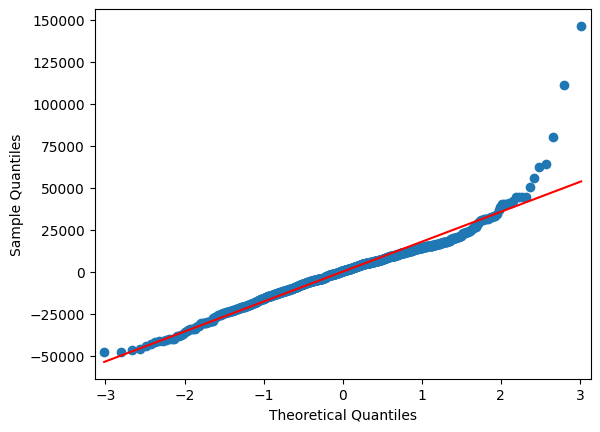

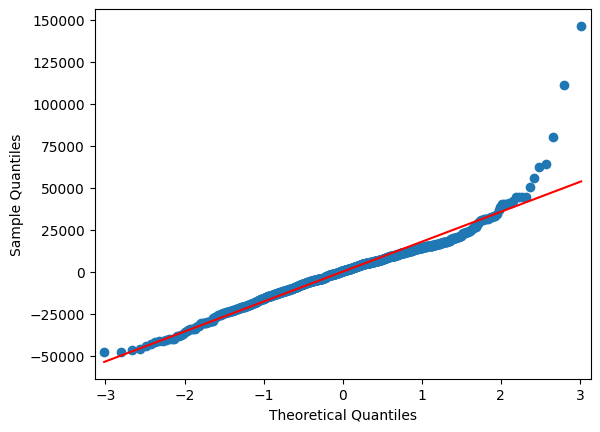

In [53]:
x=sm.add_constant(x_train)
model = sm.OLS(y_train, x_train).fit()

sm.qqplot(model.resid, line='s')
    

• Saca por pantalla la información estadística del modelo: desviación estándar de los coeficientes, valores p, intervalos de confianza de los coeficientes. Con una significancia estadística del 95%, ¿qué variables parece que no aportan
información?



Para detertar las variables que seguramente no aportan información tenemos que irnos a los p-valores más altos(siempre y cuando estos sean mayores que |t|), por lo que algunas de estas serían HouseStyle_1.5Unf, 3SsnPorch y MSSubClass_180.

In [30]:
summary=model.summary()
df_summary = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

max=df_summary['P>|t|'].max()
        
fila_con_max_pvalue = df_summary.loc[df_summary['P>|t|'] == max]

C:\Users\juanj\AppData\Local\Temp\ipykernel_19764\132737248.py:3: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_summary = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]


Paso 2: Selección de variables con statsmodels

• Implementa el siguiente algoritmo de eliminación de variables usando
statsmodels:

    1- Construye modelo con variables cols
    2- Detecta qué variables parece que no aportan información de acuerdo al
    criterio de los valores P. Si no encuentras ninguna, fin del algoritmo. Si encuentras una o varias, toma la que tenga un valor P mayor y quítala de cols. Vuelve a 1

Creamos un bucle del que saldremos solo cuando al coger el mayor de los p-valores de las variables que quedan en nuestro modelo sea menor que 0.05.
Si es mayor, pasamos a identificar el nombre de la variable de este p-valor máximo y metemos el nombre en una lista de columnas que quitamos del modelo. Después tenemos que volver a construir el modelo porque cambian los p-valores y cogemos otro máximo, y así hasta salir del bucle, que se parará cuando coja el p-valor de 0,0495 (en el summary sale que es 0,05 pero es una aproximación).

In [42]:

cols=x_train
x=sm.add_constant(cols)
model = sm.OLS(y_train, cols).fit()


#así podemos cargar en un Dataframe la segunda tabla que se nos despliega al hacer display(df.summary())


lista_cols_out=[]

while True:

    p_values=model.pvalues
    
    max=p_values.max()
    
    if max<=0.05:  #caso en el que ya no tengamos ningun pvalor mayor que el nivel de significación
        
        break
    
    lista_cols_out.append( model.pvalues.idxmax())
    model = sm.OLS(y_train, sm.add_constant(cols.drop(lista_cols_out, axis=1))).fit()
    
    
summary=model.summary() #nuevo modelo con las cols que no aportan información de acuerdo a los p-valores.
df_summary = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]
print('Num cols restantes:',len(df_summary)) #50
display(summary)

    

Num cols restantes: 68


C:\Users\juanj\AppData\Local\Temp\ipykernel_19764\2511585019.py:26: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_summary = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]


0.944144521310687

• ¿Con cuántas variables te quedas usando este algoritmo? ¿Qué R2 tiene en training y en test el nuevo modelo? ¿Es mejor que el modelo sin seleccionar variables?


Nos quedan 50 variables y un coeficiente de determinación de 0.93 con x_train, que antes de la selección de variables era de 0.991. ¿A qué se puede deber esto? Seguramente a que el modelo OLS eliminó variables que no eran estadísticamente significativas pero que contribuían a un R2 más alto, por ejemplo, tal vez se eliminaron 2 variables que estuviesen algo correlacionadas, y al quitar ambas disminuyes el coeficiente R2. El R2 para x_test es de 0.944144521.

In [33]:
x=sm.add_constant(x_train)
model_sin_selec_var = sm.OLS(y_train, x_train).fit()

print(model.rsquared,model_sin_selec_var.rsquared)



0.9363216731958053 0.9913531190091671
<class 'pandas.core.frame.DataFrame'>


Paso 3: Selección de variables con regularización

• Crea un modelo lineal usando regresión Lasso usando la clase LassoCV del módulo linear_model de sklearn. ¿Qué variables tienen peso 0 en el modelo construido? ¿es esto consistente con lo que has visto en el paso 1? ¿Qué R2 en training y test tiene tu modelo? ¿es mejor respecto a los anteriores?
 Importante: para usar regresión Lasso o Ridge, las variables de entrada al modelo y la variable target se deben estandarizar.

En el modelo construido con x_train encontramos 42 variables con un peso 0.0 en el modelo. Creemos que sí puede tener sentido, ya que, aunque esperábamos muchos más coeficientes con un peso de cero absoluto, hay muchos pesos con valores muy cercanos a cero. Las variables con estos valores tendrán un impacto mínimo en los datos, y por tanto serían eliminadas en el modelo OLS.

El coeficiente R2 para train es de 0.93607 y 0.943053 para test. Los coeficientes de x_train con los modelos OLS y Lasso son casi iguales, que ambos son 0.936 y los siguientes decimales ya son diferentes. Este dato nos hace pensar que es consistente tener 42 variables con peso 0, ya que si los coeficientes fuesen incorrectos  los coeficientes de determinación de Lasso serían menores.



In [ ]:
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler

xscaler = StandardScaler() ; xtscaler=StandardScaler()
x_train_scaled = xscaler.fit_transform(x_train) ; x_test_scaled = xtscaler.fit_transform(x_test)
#xscaler = StandardScaler(data_test)
#x_test_scaled = xscaler.fit_transform(x_test)

ymean, ystd = y_train.mean(), y_train.std()
y_train_scaled = (y_train - ymean) / ystd 
y_test_scaled = (y_test - ymean) / ystd
model = LassoCV()
model.fit(x_train_scaled, y_train_scaled)
model_test=LassoCV()
model_test.fit(x_test_scaled, y_test_scaled)
print('coef R2 de train',model.score(x_train_scaled, y_train_scaled))
print('coef R2 de test',model_test.score(x_test_scaled, y_test_scaled))
# Accede a los coeficientes del modelo Lasso
coeficientes = model.coef_

# Imprime los coeficientes junto con el nombre de las variables si tienes un DataFrame

vars_0=0 #vairables que son 0
for i, coef in enumerate(coeficientes):
    if abs(coef) == 0.0:
        vars_0 += 1
    print(f"Variable {i+1}: {coef}")

print(vars_0)





C:\Users\juanj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\juanj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\juanj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

coef R2 de train 0.936065039888586
coef R2 de test 0.9430538308722528
Variable 1: 0.007946812471808593
Variable 2: 0.10495090391772426
Variable 3: 0.007210197296199198
Variable 4: -0.0
Variable 5: -0.006584883493810619
Variable 6: -0.0024363185676723725
Variable 7: 0.19335320742891782
Variable 8: 0.08131931922201234
Variable 9: 0.10041114108917054
Variable 10: 0.0072530298802548675
Variable 11: -0.0285455951516634
Variable 12: 0.10678120829771648
Variable 13: 0.06431425282142166
Variable 14: -0.0
Variable 15: 0.0
Variable 16: -0.051335118675894915
Variable 17: 0.08053832727079373
Variable 18: 0.0019484028066113128
Variable 19: -0.0
Variable 20: -0.01814140056454692
Variable 21: -0.09143919639122441
Variable 22: 0.20001613802605814
Variable 23: -0.0
Variable 24: 0.012445242530289103
Variable 25: 0.0
Variable 26: 0.0
Variable 27: 0.030439710875898317
Variable 28: -0.0
Variable 29: 0.38145439533786285
Variable 30: 0.014477394001710421
Variable 31: 0.0018497312484377921
Variable 32: -0.001

C:\Users\juanj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\juanj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\juanj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instea

• Repite el punto anterior usando regresión Ridge

Esta vez haciendo el modelo con Ridge nos encontramos que no hay ningún coeficiente con peso 0, pero esto es normal: a diferencia de Lasso, que utiliza la regularización L1 y tiene la propiedad de forzar algunos coeficientes a ser exactamente cero, Ridge utiliza la regularización L2, que penaliza los coeficientes sin eliminarlos por completo. Los coeficientes no se suelen anular por completo a no ser que aumentemos alpha : de hecho, cuanto mayor mayor es alfa mayor es la regularización y menores serán los coeficientes.

En cuanto a los coeficientes R2, en x_train es de 0.94244854108293460 y x_test 0.9563741000674629, por lo que se ajustan mejor nuestros datos al modelo Ridge en comparación al resto de modelos.

In [52]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0)  
ridge_model.fit(x_train_scaled, y_train_scaled)
r2 = ridge_model.score(x_train_scaled, y_train_scaled)
ridge_model_t = Ridge(alpha=1.0)  
ridge_model_t.fit(x_test_scaled, y_test_scaled)
r2t=ridge_model_t.score(x_test_scaled, y_test_scaled)

print("Coeficiente de Determinación de train", r2)
print("Coeficiente de Determinación de test", r2t)

coeficientes=ridge_model.coef_

vars_0=0 #variables que son 0
for i, coef in enumerate(coeficientes):
    if abs(coef) == 0.0:
        vars_0 += 1
    print(f"Variable {i+1}: {coef}")

print(vars_0)



Coeficiente de Determinación de train 0.9424485410829346
Coeficiente de Determinación de test 0.9563741000674629
Variable 1: 0.008912292546360648
Variable 2: 0.1111378131070638
Variable 3: 0.005406202578406395
Variable 4: -0.010249461845220513
Variable 5: -0.010603952129331583
Variable 6: -0.016942449145938794
Variable 7: 0.18275838515805337
Variable 8: 0.0932746038055267
Variable 9: 0.15886042141810824
Variable 10: 0.008659042587385151
Variable 11: -0.03778253686451962
Variable 12: 0.12141359707650147
Variable 13: 0.06397677388229743
Variable 14: -0.006719147779648538
Variable 15: 0.0046795616258589546
Variable 16: -0.07468830686802223
Variable 17: 0.08510303552754354
Variable 18: -0.011835970749203461
Variable 19: 0.004040019204840276
Variable 20: -0.030249095907332515
Variable 21: -0.10528388582273075
Variable 22: 0.23514181767069928
Variable 23: -0.005787816022702583
Variable 24: 0.01827838681579509
Variable 25: -0.0025721867702924125
Variable 26: 0.013330735701261441
Variable 27: 

C:\Users\juanj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\juanj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\juanj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instea